# maps of AGI change
# Here: use drift-corrected files
# Fig.S4 in paper

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib import cm
from netCDF4 import Dataset, MFDataset
import pandas as pd
from matplotlib.patches import Rectangle
import copy
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from pathlib import Path
import xarray as xr


In [2]:
#------
# MODEL INFO
#------

years = np.arange(1980,2100+1,1)
print (years)

savepath    = '/global/cfs/cdirs/m4003/cnissen/Plots/AGI_project/change_AGI_with_drift_corr/'
if not os.path.exists(savepath):
    print('Created '+savepath)
    os.makedirs(savepath)

savepath2    = '/global/cfs/cdirs/m4003/cnissen/Plots/AGI_project/change_AGI_with_drift_corr/eps/'
if not os.path.exists(savepath2):
    print('Created '+savepath2)
    os.makedirs(savepath2)
    
#---
# load mesh info
#---

path_mesh = '/pscratch/sd/c/cnissen/'
file_mesh = 'Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'

f1 = Dataset(path_mesh+file_mesh) #xr.open_dataset(path+file1)
lat_model      = f1.variables['lat'][:]
lon_model      = f1.variables['lon'][:]
zlevs    = f1.variables['zlevs'][:]
cavities = f1.variables['cavity'][:]
topo     = f1.variables['topo'][:]
area     = f1.variables['cell_area'][:]
volume   = f1.variables['cell_volume'][:]
f1.close()
print(lat_model.shape)

ind_no_cavity = np.where(cavities==0)[0]
ind_cavities = np.where(cavities==1)[0]


[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035
 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049
 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063
 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077
 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091
 2092 2093 2094 2095 2096 2097 2098 2099 2100]
(72411,)


In [3]:
#-----
# based on python code provided by Anne
#-----

basepath="/pscratch/sd/c/cnissen/AGI_toothfish_project/" 
no_species=29

# Init
species_names         = [None] * no_species # empty list
species_names_        = [None] * no_species # empty list
habitat_file_names    = [None] * no_species # empty list

habitat_files = Path(basepath + "all_prey_plus_toothfish/").glob('*_boolean.nc')  # updated habitat files, Nov 2022!!!!!!
#habitat_files = Path(basepath + "share/").glob('*_boolean.nc') 
# Note: I changed name of file of Antimora_rostrata to *boolean2.nc, so that it won't be included here
for ifile,file in enumerate(habitat_files):   
    habitat_file_names[ifile]    = str(file)
    # Get the species name from the full pathname with a space between
    species_names[ifile]  = '_'.join(os.path.basename(file).split('_')[:-2]).replace('_',' ') 
    if not species_names[ifile] in ['Galiteuthis glacialis','Mesonychoteuthis hamiltoni','Kondakovia longimana']:
        species_names[ifile] = species_names[ifile][8:] # get rid of "Default" or "Reviewed"
    if species_names[ifile][0].isspace():  # get rid of white space if there is any
        species_names[ifile] = species_names[ifile][1:]
    if species_names[ifile] in ['Chionobathyscus dewitti All Suitable Habitat']:
        species_names[ifile] = species_names[ifile][0:23]
    # Get the species name from the full pathname with _ in it
    species_names_[ifile] = species_names[ifile].replace(' ','_')  #'_'.join(os.path.basename(file).split('_')[:-2]) 

#print(habitat_file_names)
print(species_names)
print(len(species_names),'species')
print(species_names_)


['Dissostichus mawsoni', 'Trematomus loennbergii', 'Macrourus whitsoni', 'Galiteuthis glacialis', 'Chionodraco hamatus', 'Anotopterus vorax', 'Chaenodraco wilsoni', 'Kondakovia longimana', 'Cryodraco antarcticus', 'Muraenolepis microps', 'Psychroteuthis glacialis', 'Gymnodraco acuticeps', 'Amblyraja georgiana', 'Antarctomysis maxima', 'Lepidonotothen squamifrons', 'Mesonychoteuthis hamiltoni', 'Pleuragramma antarctica', 'Euphausia superba', 'Notothenia coriiceps', 'Trematomus lepidorhinus', 'Pagothenia borchgrevinki', 'Lycenchelys aratrirostris', 'Neopagetopsis ionah', 'Chaenocephalus aceratus', 'Trematomus hansoni', 'Chionobathyscus dewitti', 'Euphausia crystallorophias', 'Notothenia rossii', 'Bathyraja maccaini']
29 species
['Dissostichus_mawsoni', 'Trematomus_loennbergii', 'Macrourus_whitsoni', 'Galiteuthis_glacialis', 'Chionodraco_hamatus', 'Anotopterus_vorax', 'Chaenodraco_wilsoni', 'Kondakovia_longimana', 'Cryodraco_antarcticus', 'Muraenolepis_microps', 'Psychroteuthis_glacialis'

In [4]:
#----
# Species information needed for calculation AGI
#----

# define order of species as contained in depth_min, LWa etc.
species_list = ['Cryodraco antarcticus','Neopagetopsis ionah','Trematomus lepidorhinus',\
               'Trematomus hansoni','Bathyraja maccaini','Chaenocephalus aceratus',\
               'Notothenia coriiceps','Pleuragramma antarctica','Dissostichus mawsoni',\
                'Macrourus whitsoni',\
               'Lepidonotothen squamifrons','Notothenia rossii','Muraenolepis microps',\
               'Chaenodraco wilsoni','Chionobathyscus dewitti',\
               'Galiteuthis glacialis','Mesonychoteuthis hamiltoni','Kondakovia longimana',\
               'Amblyraja georgiana','Anotopterus vorax','Antarctomysis maxima',\
               'Chionodraco hamatus','Euphausia crystallorophias','Euphausia superba','Gymnodraco acuticeps',\
               'Lycenchelys aratrirostris','Pagothenia borchgrevinki','Psychroteuthis glacialis',\
               'Trematomus loennbergii']
print(len(species_list))
# excluded the following species for now: 
# 1) Antimora rostrata: don't have the habitat file (habitat outside of SO)

# NO MAP Bathyraja eatonii	?		15	1500

# Minimum depth of occurence (meter)
depth_min     = [None] * len(species_names) # Initialize
depth_min[0]  = 90   # 'Cryodraco antarcticus'
depth_min[1]  = 20   #'Neopagetopsis ionah'
depth_min[2]  = 272    # 'Trematomus lepidorhinus'
depth_min[3]  = 6    # 'Trematomus hansoni'
depth_min[4]  = 167  # 'Bathyraja maccaini'
depth_min[5]  = 0    # 'Chaenocephalus aceratus'
depth_min[6]  = 0    # 'Notothenia coriiceps'
depth_min[7]  = 0    # 'Pleuragramma antarctica'
depth_min[8]  = 0    # 'Dissostichus mawsoni' ## Assume a wide range for toothfish (max. overlap with prey) ##
depth_min[9]  = 400  # 'Macrourus whitsoni'
depth_min[10] = 10   # 'Lepidonotothen squamifrons'
depth_min[11] = 5    # 'Notothenia rossii'
depth_min[12] = 10   # 'Muraenolepis microps'
depth_min[13] = 200  # 'Chaenodraco wilsoni'
depth_min[14] = 500  # 'Chionobathyscus dewitti'
depth_min[15] = 200   #'Galiteuthis glacialis'
depth_min[16] = 200   # 'Mesonychoteuthis hamiltoni'
depth_min[17] = 500   # 'Kondakovia longimana'
depth_min[18] = 57    # Amblyraja georgiana
depth_min[19] = 358  # Anotopterus vorax
depth_min[20] = 220 # Antarctomysis maxima
depth_min[21] = 76 # Chionodraco hamatus
depth_min[22] = 0 # Euphausia crystallorophias
depth_min[23] = 0 # Euphausia superba
depth_min[24] = 66 # Gymnodraco acuticeps
depth_min[25] = 244 # Lycenchelys aratrirostris
depth_min[26] = 0 # Pagothenia borchgrevinki
depth_min[27] = 385 # Psychroteuthis glacialis
depth_min[28] = 65 # Trematomus loennbergii
#depth_min[29] = # Trematomus eulepidotus #EXCLUDED

# Maximum depth of occurence (meter)
depth_max     = [None] * len(species_names) # Initialize
depth_max[0]  = 600  # 'Cryodraco antarcticus'
depth_max[1]  = 900  #'Neopagetopsis ionah'
depth_max[2]  = 468  # 'Trematomus lepidorhinus'
depth_max[3]  = 549  # 'Trematomus hansoni'
depth_max[4]  = 500  # 'Bathyraja maccaini'
depth_max[5]  = 770  # 'Chaenocephalus aceratus'
depth_max[6]  = 550  # 'Notothenia coriiceps'
depth_max[7]  = 1000 # 'Pleuragramma antarctica'
depth_max[8]  = 2210   # 'Dissostichus mawsoni' ## Assume a wide range for toothfish (max. overlap with prey) ##
depth_max[9]  = 3185 # 'Macrourus whitsoni'
depth_max[10] = 900  # 'Lepidonotothen squamifrons'
depth_max[11] = 350 # 'Notothenia rossii'
depth_max[12] = 1600 # 'Muraenolepis microps'
depth_max[13] = 800  # 'Chaenodraco wilsoni'
depth_max[14] = 2000 # 'Chionobathyscus dewitti'
depth_max[15] = 2500   #'Galiteuthis glacialis'
depth_max[16] =  600  # 'Mesonychoteuthis hamiltoni'
depth_max[17] = 2000   # 'Kondakovia longimana'
depth_max[18] = 173    # Amblyraja georgiana
depth_max[19] = 1059 # Anotopterus vorax
depth_max[20] = 440 # Antarctomysis maxima
depth_max[21] = 271 # Chionodraco hamatus
depth_max[22] = 650 # Euphausia crystallorophias
depth_max[23] = 600 # Euphausia superba
depth_max[24] = 247 # Gymnodraco acuticeps
depth_max[25] = 376 # Lycenchelys aratrirostris
depth_max[26] = 30 # Pagothenia borchgrevinki
depth_max[27] = 610 # Psychroteuthis glacialis
depth_max[28] = 832 # Trematomus loennbergii
#depth_max[29] = # Trematomus eulepidotus EXCLUDED

#---
# NOTE Jan 2023: this info below is not needed anymore with the new AGI formulation!
#----
## LWa extracted 21.07.2022 from FishBase
#LWa     = [None] * len(species_names) # Initialize
#LWa[0]  = 0.0007  # 'Cryodraco antarcticus'
#LWa[1]  = 0.01863  #'Neopagetopsis ionah'
#LWa[2]  = 0.0042  # 'Trematomus eulepidotus'
#LWa[3]  = 0.0021  # 'Trematomus hansoni'
#LWa[4]  = 0.00477  # 'Bathyraja maccaini'
#LWa[5]  = 0.0006 # 'Chaenocephalus aceratus'
#LWa[6]  = 0.0132  # 'Notothenia coriiceps'
#LWa[7]  = 0.0019  # 'Pleuragramma antarctica'
#LWa[8]  = 0.0045   # 'Dissostichus mawsoni'
#LWa[9]  = 0.0135 # 'Macrourus whitsoni'
#LWa[10] = 0.0027  # 'Lepidonotothen squamifrons'
##LWa[11] = 0.001     # 'Antimora rostrata'
#LWa[11] = 0.0093 # 'Notothenia rossii'
#LWa[12] = 0.00437 # 'Muraenolepis microps'
#LWa[13] = 0.0005  # 'Chaenodraco wilsoni'
#LWa[14] = 0.0012 # 'Chionobathyscus dewitti'

## LWb extracted 21.07.2022 from FishBase
#LWb     = [None] * len(species_names) # Initialize
#LWb[0]  = 3.51  # 'Cryodraco antarcticus'
#LWb[1]  = 2.762  #'Neopagetopsis ionah'
#LWb[2]  = 3.32  # 'Trematomus eulepidotus'
#LWb[3]  = 3.52  # 'Trematomus hansoni'
#LWb[4]  = 3.162  # 'Bathyraja maccaini'
#LWb[5]  = 3.63  # 'Chaenocephalus aceratus'
#LWb[6]  = 3.09  # 'Notothenia coriiceps'
#LWb[7]  = 3.41  # 'Pleuragramma antarctica'
#LWb[8]  = 3.24   # 'Dissostichus mawsoni'
#LWb[9]  = 3.15 # 'Macrourus whitsoni'
#LWb[10] = 3.41  # 'Lepidonotothen squamifrons'
##LWb[11] = 3.52   # 'Antimora rostrata'
#LWb[11] = 3.07 # 'Notothenia rossii'
#LWb[12] = 3.11 # 'Muraenolepis microps'
#LWb[13] = 3.79  # 'Chaenodraco wilsoni'
#LWb[14] = 3.5 # 'Chionobathyscus dewitti'

## Linf extracted 21.07.2022 from FishBase
## * Linf estimated from Lmax using Froese and Binohlan (2000) Eq. (5).
#Linf     = [None] * len(species_names) # Initialize
#Linf[0]  = 50.66374052  # 'Cryodraco antarcticus'*
#Linf[1]  = 58.12886422  #'Neopagetopsis ionah'*
#Linf[2]  = 26.5  # 'Trematomus eulepidotus'
#Linf[3]  = 36.5  # 'Trematomus hansoni'
#Linf[4]  = 123.061517  # 'Bathyraja maccaini'*
#Linf[5]  = 70.4  # 'Chaenocephalus aceratus'
#Linf[6]  = 62  # 'Notothenia coriiceps'
#Linf[7]  = 25.1  # 'Pleuragramma antarctica'
#Linf[8]  = 183   # 'Dissostichus mawsoni'
#Linf[9]  = 92 # 'Macrourus whitsoni'
#Linf[10] = 56.7  # 'Lepidonotothen squamifrons'
##Linf[11] = 66   # 'Antimora rostrata'
#Linf[11] = 87 # 'Notothenia rossii'
#Linf[12] = 36.60305736 # 'Muraenolepis microps'*
#Linf[13] = 44.82252387  # 'Chaenodraco wilsoni'*
#Linf[14] = 62.21264207 # 'Chionobathyscus dewitti'*


29


In [5]:
#----
# get indices of depth levels of species
#----

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

file_mesh = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/Mesh_ancillary_information_v20220919.nc'
data_levels = xr.open_dataset(file_mesh)
levels      = data_levels['depth'].values # 88 levels
lat      = data_levels['lat'].values
lon      = data_levels['lon'].values
mask        = data_levels['mask_vol'].values
data_levels.close()

index_min_depth     = [None] * len(species_names) # Initialize
index_max_depth     = [None] * len(species_names) # Initialize

for i,name in enumerate(species_names):
    # Note Cara: order of entries in depth_min etc. is not alphabetical!!!!
    # here, I have adapted the index from "i" to "iii" to read in the correct depth ranges
    # for the current species
    iii = species_list.index(species_names[i]) # get index of current species as contained in depth_min etc.
    index_min_depth[i] = find_nearest(levels,depth_min[iii])
    index_max_depth[i] = find_nearest(levels,depth_max[iii])
    # now, index_min_depth should contain the correct values according to alphabetical order as looped over
    # NOTE: given how python is indexing, I think I then need to index over index_min_depth:index_max_depth+1
    # (was index_min_depth:index_max_depth before)
    

In [6]:
#-----
# calculate AGI from annual mean fields
#-----

# constants
d = 0.7 # n.d.; metabolic scaling coefficient
j1 = 4500 # K; "Anabolism activation energy divided by Boltzmann constant" (Clarke2021)
j2 = 8000 # K; "Catabolism activation energy divided by Boltzmann constant" (Clarke2021)
j_diff = j2-j1
# from Clarke2021: "Somatic (or biomass) growth can be expressed as the difference between anabolism and catabolism"

#---
# load AGIcrit, Tpref, O2thresh
#---

# Init
AGI_crit = [None] * no_species # empty list
o2thresh = [None] * no_species # empty list
TPref    = [None] * no_species # empty list

based_on_monthly_clim_AGIcrit = True # if False, use AGIcrit calculated based on annual mean climatology

# AGIcrit 
for ii in range(0,len(species_names)):
    if based_on_monthly_clim_AGIcrit:
        file = 'AGIcrit_'+species_names_[ii]+'_based_on_monthly_clim_1995_2014.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/'+file)
    else:
        file = 'AGIcrit_'+species_names_[ii]+'_based_on_annual_clim_1995_2014.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/based_on_annual/'+file)
    AGI_crit[ii]        = ff['AGIcrit'].values[0]
    ff.close()
    
# o2thresh  
for ii in range(0,len(species_names)):
    if based_on_monthly_clim_AGIcrit:
        file = 'o2thresh_'+species_names_[ii]+'_based_on_monthly_clim_1995_2014.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/'+file)
    else:
        file = 'o2thresh_'+species_names_[ii]+'_based_on_annual_clim_1995_2014.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/based_on_annual/'+file)
    o2thresh[ii]        = ff['o2thresh'].values[0]
    ff.close()
    
# TPref 
for ii in range(0,len(species_names)):
    if based_on_monthly_clim_AGIcrit:
        file = 'Tpref_'+species_names_[ii]+'_based_on_monthly_clim_1995_2014.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/'+file)
    else:
        file = 'Tpref_'+species_names_[ii]+'_based_on_annual_clim_1995_2014.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/based_on_annual/'+file)
    TPref[ii]        = ff['Tpref'].values[0]
    ff.close()

#-----
# NOTE that order of species in LWa etc is not the same as in "species_names"
# account for that further down!!!!
#-----
# calculate Winf and W for each species
# UPDATE Jan 2023: the info below is not needed anymore with updated calculation of AGI
# calculate Winf and W for each species
#Winf = np.asarray(LWa)*(np.asarray(Linf)**np.asarray(LWb))
#W    = (1./3.)*Winf
#print('Winf:',Winf)
#print('AGI_crit:',AGI_crit)
#print('o2thresh:',o2thresh)
#print('TPref:',TPref)

#--------
# NOTE: I don't think the order provided in LWa,LWb & Linf matches the order in which AGIcrit etc are loaded here!
# careful when indexing
# -> see above for finding the indices for the depth range!
#--------


In [7]:
#-----
# calculate AGI based on annual fields
# part I: load pO2 & t_insitu fields
#-----

which_sim = 'simAssp585' # for present-day, keep this as simAssp585! 
path1 = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/'+which_sim+'_reduced/'

#----
# PRESENT-DAY
#----

year_list1 = np.arange(1995,2014+1,1)

for yy in range(0,len(year_list1)):
    year1 = year_list1[yy]
    print('Load year ',year1)
    
    # pO2 data (mbar)
    file_pO2  = path1+'/pO2_fesom_'+which_sim+'_'+str(year1)+'0101_v2.nc'
    data_pO2   = xr.open_dataset(file_pO2)
    a1 = data_pO2['pO2'].values
    a1 = np.ma.masked_where(a1<0,a1)
    print('Min/Max pO2:',np.nanmin(a1),np.nanmax(a1))
    if yy==0:
        pO2_1      = a1 #data_pO2['pO2'].values
    else:
        pO2_1      = pO2_1+ a1 #data_pO2['pO2'].values
    data_pO2.close()
    del a1

    # T insitu (deg C)
    file_t_insitu   = path1+'/t_insitu_fesom_'+which_sim+'_'+str(year1)+'0101_v2.nc'
    data_t_insitu   = xr.open_dataset(file_t_insitu)
    a1 = data_t_insitu['t_insitu'].values
    a1 = np.ma.masked_where(a1<-3.0,a1)
    print('Min/Max t_insitu:',np.nanmin(a1),np.nanmax(a1))
    #print('Min/Max t_insitu:',np.min(data_t_insitu['t_insitu'].values),np.max(data_t_insitu['t_insitu'].values))
    if yy==0:
        t_insitu_1        = a1 #data_t_insitu['t_insitu'].values
    else:
        t_insitu_1        = t_insitu_1+ a1 #data_t_insitu['t_insitu'].values
    data_t_insitu.close()
    del a1
    
# calculate climatology
t_insitu_1 = t_insitu_1/len(year_list1)
pO2_1      = pO2_1/len(year_list1)
print('')
print('Min/Max t_insitu:',np.nanmin(t_insitu_1),np.nanmax(t_insitu_1))
print('Min/Max pO2:',np.nanmin(pO2_1),np.nanmax(pO2_1))
    
print('done')


Load year  1995
Min/Max pO2: 4.207563 225.77884
Min/Max t_insitu: -2.571443 15.545197
Load year  1996
Min/Max pO2: 2.8013957 225.59848
Min/Max t_insitu: -2.575366 14.551913
Load year  1997
Min/Max pO2: 1.8041228 225.43907
Min/Max t_insitu: -2.5624118 15.000496
Load year  1998
Min/Max pO2: 0.027826557 225.30064
Min/Max t_insitu: -2.5636892 15.028485
Load year  1999
Min/Max pO2: 1.8957909 225.04358
Min/Max t_insitu: -2.5640612 14.615901
Load year  2000
Min/Max pO2: 9.454568 224.61386
Min/Max t_insitu: -2.5593815 15.245595
Load year  2001
Min/Max pO2: 3.726922 224.15968
Min/Max t_insitu: -2.5575552 15.217681
Load year  2002
Min/Max pO2: 2.2234223 223.76306
Min/Max t_insitu: -2.5549266 14.752597
Load year  2003
Min/Max pO2: 2.194433 224.76065
Min/Max t_insitu: -2.5629275 15.570725
Load year  2004
Min/Max pO2: 2.6431694 229.60274
Min/Max t_insitu: -2.5545547 16.359056
Load year  2005
Min/Max pO2: 1.7453376 229.03206
Min/Max t_insitu: -2.5574455 14.253276
Load year  2006
Min/Max pO2: 3.34010

In [43]:
#-----
# calculate AGI based on annual fields
# part I: load pO2 & t_insitu fields
#-----

which_sim = 'ssp585'

# load drift-corrected files 
which_drift = '2091_2100' # 2081_2100, 2091_2100, 2098_2100; for attribuion analysis, files are only available for 2091_2100
drift_corr ='monthly_drift_corrected_'+which_drift+'_minus_1995_2014_v2' 

path1 = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/'+which_sim+'_reduced/' # contains the drift-corrected files for the future
path2 = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/simA'+which_sim+'_reduced/' # contains the files fort he present-day

which_exp = '_Temp_historical' # both_change (=both temp and O2 change), _O2_historical (temperature contribution), _Temp_historical (O2 contribution)

#----
# FUTURE
#----

year_list2 = np.arange(int(which_drift[0:4]),int(which_drift[5:])+1,1)

if which_exp in ['both_change']:
    print('Both temperature and O2 change...')
    for yy in range(0,len(year_list2)):
        year2 = year_list2[yy]
        print('Load year ',year2)

        # pO2 data (mbar)
        file_pO2  = path1+'/pO2_fesom_'+which_sim+'_'+str(year2)+'0101_'+drift_corr+'.nc'
        data_pO2   = xr.open_dataset(file_pO2)
        if yy==0:
            print('Load depth levels')
            depths = data_pO2['depth'].values
        a1 = data_pO2['pO2'].values
        a1 = np.ma.masked_where(a1<0,a1)
        print('Min/Max pO2:',np.nanmin(a1),np.nanmax(a1))
        if yy==0:
            pO2_2      = a1 #data_pO2['pO2'].values
        else:
            pO2_2      = pO2_2+ a1 #data_pO2['pO2'].values
        data_pO2.close()
        del a1

        # T insitu (deg C)
        file_t_insitu   = path1+'/t_insitu_fesom_'+which_sim+'_'+str(year2)+'0101_'+drift_corr+'.nc'
        data_t_insitu   = xr.open_dataset(file_t_insitu)
        a1 = data_t_insitu['t_insitu'].values
        a1 = np.ma.masked_where(a1<-3.0,a1)
        print('Min/Max t_insitu:',np.nanmin(a1),np.nanmax(a1))
        #print('Min/Max t_insitu:',np.min(data_t_insitu['t_insitu'].values),np.max(data_t_insitu['t_insitu'].values))
        if yy==0:
            t_insitu_2        = a1 #data_t_insitu['t_insitu'].values
        else:
            t_insitu_2        = t_insitu_2+ a1 #data_t_insitu['t_insitu'].values
        data_t_insitu.close()
        del a1
    # calculate climatology (Note that the different time periods have different number of years!!!!)
    t_insitu_2 = t_insitu_2/len(year_list2)
    pO2_2      = pO2_2/len(year_list2)
elif which_exp in ['_Temp_historical']:
    print('Temperature is held at present-day levels, O2 changes (temp effect in O2 change is NOT considered!)...')
    for yy in range(0,len(year_list2)):
        year2 = year_list2[yy]
        print('Load year ',year2)
        #----
        # pO2 data (mbar)
        #----
        file_pO2  = path1+'/pO2_fesom_'+which_sim+'_'+str(year2)+'0101_at_climatological_t_insitu_'+drift_corr+'.nc'
        data_pO2   = xr.open_dataset(file_pO2)
        if yy==0:
            print('Load depth levels')
            depths = data_pO2['depth'].values
        a1 = data_pO2['pO2'].values
        a1 = np.ma.masked_where(a1<0,a1)
        print('Min/Max pO2:',np.nanmin(a1),np.nanmax(a1))
        if yy==0:
            pO2_2      = a1 #data_pO2['pO2'].values
        else:
            pO2_2      = pO2_2+ a1 #data_pO2['pO2'].values
        data_pO2.close()
        del a1
    for yy in range(0,len(year_list1)):
        year2 = year_list1[yy]
        print('Load year ',year2)
        #----
        # T insitu (deg C)
        #----
        file_t_insitu   = path2+'/t_insitu_fesom_simA'+which_sim+'_'+str(year2)+'0101_v2.nc'
        data_t_insitu   = xr.open_dataset(file_t_insitu)
        a1 = data_t_insitu['t_insitu'].values
        a1 = np.ma.masked_where(a1<-3.0,a1)
        print('Min/Max t_insitu:',np.nanmin(a1),np.nanmax(a1))
        #print('Min/Max t_insitu:',np.min(data_t_insitu['t_insitu'].values),np.max(data_t_insitu['t_insitu'].values))
        if yy==0:
            t_insitu_2        = a1 #data_t_insitu['t_insitu'].values
        else:
            t_insitu_2        = t_insitu_2+ a1 #data_t_insitu['t_insitu'].values
        data_t_insitu.close()
        del a1
    # calculate climatology (Note that the different time periods have different number of years!!!!)
    t_insitu_2 = t_insitu_2/len(year_list1)
    pO2_2      = pO2_2/len(year_list2)
elif which_exp in ['_O2_historical']:
    print('O2 is held at present-day levels, temperature changes...')
    for yy in range(0,len(year_list1)):
        year2 = year_list1[yy]
        print('Load year ',year2)
        #----
        # pO2 data (mbar)
        #----
        file_pO2  = path2+'/pO2_fesom_simA'+which_sim+'_'+str(year2)+'0101_v2.nc'
        data_pO2   = xr.open_dataset(file_pO2)
        if yy==0:
            print('Load depth levels')
            depths = data_pO2['depth'].values
        a1 = data_pO2['pO2'].values
        a1 = np.ma.masked_where(a1<0,a1)
        print('Min/Max pO2:',np.nanmin(a1),np.nanmax(a1))
        if yy==0:
            pO2_2      = a1 #data_pO2['pO2'].values
        else:
            pO2_2      = pO2_2+ a1 #data_pO2['pO2'].values
        data_pO2.close()
        del a1
    for yy in range(0,len(year_list2)):
        year2 = year_list2[yy]
        print('Load year ',year2)
        #----
        # T insitu (deg C)
        #----
        file_t_insitu   = path1+'/t_insitu_fesom_'+which_sim+'_'+str(year2)+'0101_'+drift_corr+'.nc'
        data_t_insitu   = xr.open_dataset(file_t_insitu)
        a1 = data_t_insitu['t_insitu'].values
        a1 = np.ma.masked_where(a1<-3.0,a1)
        print('Min/Max t_insitu:',np.nanmin(a1),np.nanmax(a1))
        #print('Min/Max t_insitu:',np.min(data_t_insitu['t_insitu'].values),np.max(data_t_insitu['t_insitu'].values))
        if yy==0:
            t_insitu_2        = a1 #data_t_insitu['t_insitu'].values
        else:
            t_insitu_2        = t_insitu_2+ a1 #data_t_insitu['t_insitu'].values
        data_t_insitu.close()
        del a1
    # calculate climatology (Note that the different time periods have different number of years!!!!)
    t_insitu_2 = t_insitu_2/len(year_list2)
    pO2_2      = pO2_2/len(year_list1)
    
# volume data 
data_vol   = xr.open_dataset(file_mesh)
vol        = data_vol['volume']
data_vol.close()

#print(vol.shape)
#print(t_insitu_2.shape)
#print(pO2_2.shape)

print('')
print('Min/Max t_insitu:',np.nanmin(t_insitu_2),np.nanmax(t_insitu_2))
print('Min/Max pO2:',np.nanmin(pO2_2),np.nanmax(pO2_2))

# to be checked: without this step, temp minimum is -41 or so for future... why?
#t_insitu_1[t_insitu_1<-5]=np.nan
#t_insitu_2[t_insitu_2<-5]=np.nan
#print('min/max t_insitu_2:',np.nanmin(t_insitu_2),np.nanmax(t_insitu_2))
#t_insitu_1 = np.ma.masked_where(t_insitu_1<-40,t_insitu_1)
#t_insitu_2 = np.ma.masked_where(t_insitu_2<-40,t_insitu_2)
##print('min/max t_insitu_1:',np.nanmin(t_insitu_1),np.nanmax(t_insitu_1))
#print('min/max t_insitu_2:',np.nanmin(t_insitu_2),np.nanmax(t_insitu_2))

print('done')


Temperature is held at present-day levels, O2 changes (temp effect in O2 change is NOT considered!)...
Load year  2091
Load depth levels
Min/Max pO2: 0.18407229 17637.645
Load year  2092
Min/Max pO2: 0.18615732 17686.783
Load year  2093
Min/Max pO2: 0.20951661 17722.39
Load year  2094
Min/Max pO2: 0.21596994 17684.303
Load year  2095
Min/Max pO2: 0.21790534 17646.326
Load year  2096
Min/Max pO2: 0.22117929 17651.314
Load year  2097
Min/Max pO2: 0.22600251 17686.174
Load year  2098
Min/Max pO2: 0.20842564 17655.496
Load year  2099
Min/Max pO2: 0.20978917 17684.57
Load year  2100
Min/Max pO2: 0.20297498 17708.943
Load year  1995
Min/Max t_insitu: -2.571443 15.545197
Load year  1996
Min/Max t_insitu: -2.575366 14.551913
Load year  1997
Min/Max t_insitu: -2.5624118 15.000496
Load year  1998
Min/Max t_insitu: -2.5636892 15.028485
Load year  1999
Min/Max t_insitu: -2.5640612 14.615901
Load year  2000
Min/Max t_insitu: -2.5593815 15.245595
Load year  2001
Min/Max t_insitu: -2.5575552 15.21768

In [44]:
#--- 
# understand sensitivities in AGI equation
#---

def get_AGI_testing(i,d,pO2,t_insitu,species_names,TPref,o2thresh,j_diff):
    
    # order of species in W, Winf etc not the same as in this i-loop!
    # correct for that here (same was done for index_min_depth and index_max_depth)
    iii = species_list.index(species_names[i])
    print(species_names[i])
    
    #------
    # get Tpref & O2thresh -> see plot_AGI_toothfish_TPref_O2thresh_save_as_netcdf.ipynb
    #   Tpref: 50th percentile in habitat (volume weighted)
    #   O2thresh: 10th percentile in habitat (volume weighted)
    tpref_species    = TPref[i]
    o2thresh_species = o2thresh[i]   
    #print('Reference temperature & O2 threshold:',tpref_species,o2thresh_species)
    #------
    
    w_ratio = ((1./3.)**(1-d))
    a1 = np.exp((j_diff/(tpref_species+273.15)) - (j_diff/(t_insitu+273.15)))
    
    AGI = pO2/(o2thresh_species*w_ratio*a1)
    
    return AGI 

i = 0

data_pO2 = 100
data_temp = 5
AGI_test = get_AGI_testing(i,d,data_pO2,data_temp,species_names,TPref,o2thresh,j_diff)
print('pO2 & temp:',data_pO2,data_temp)
print('AGI_test:',AGI_test)

print()
data_pO2 = 100
data_temp = 8
AGI_test = get_AGI_testing(i,d,data_pO2,data_temp,species_names,TPref,o2thresh,j_diff)
print('pO2 & temp:',data_pO2,data_temp)
print('AGI_test:',AGI_test)

print()
data_pO2 = 50
data_temp = 5
AGI_test = get_AGI_testing(i,d,data_pO2,data_temp,species_names,TPref,o2thresh,j_diff)
print('pO2 & temp:',data_pO2,data_temp)
print('AGI_test:',AGI_test)


Dissostichus mawsoni
pO2 & temp: 100 5
AGI_test: 0.9210011027455575

Dissostichus mawsoni
pO2 & temp: 100 8
AGI_test: 0.8052826621501875

Dissostichus mawsoni
pO2 & temp: 50 5
AGI_test: 0.46050055137277873


In [45]:
#----
# functions
#----

def get_AGI(i,hab_field,vol,pO2,t_insitu,index_min_depth,index_max_depth,\
                                    species_list,species_names,TPref,o2thresh,AGI_crit,j_diff,mask):
    # NOTE: "mask" is 2D field; can be an MPA or the whole Southern Ocean (array of ones in this case)
    
    # turn mask into 3D
    mask3D = np.tile(mask,[88,1,1])
    #mask3D = mask3D[index_min_depth[i]:index_max_depth[i]+1,:,:] # select depth levels of interest
    
    # HERE: keep all depth levels! I want to plot maps
  #  # set mask outside of depth range to zero
  #  if index_min_depth[i]>0:
  #      mask3D[0:index_min_depth[i]:,:] = 0
  #  mask3D[index_max_depth[i]:,:,:] = 0
    
    ### select the data/volume over the relevant depth range, correct with habitat array
    # NOTE: index_min_depth[i]:index_max_depth[i]    or.    index_min_depth[i]:index_max_depth[i]+1   ?
    vol_inhabitat = (vol.values[:,:,:]*hab_field*mask3D) 
    dataout1      = (pO2[:,:,:]*hab_field*mask3D)
    dataout2      = (t_insitu[:,:,:]*hab_field*mask3D)
    #print(dataout1.shape) # depth x lat x lon
    
    # use all months -> don't "ravel" here to keep the depths x lat x lon format
    dataout1b = dataout1[:,:,:] #.ravel() # pO2
    dataout2b = dataout2[:,:,:] #.ravel() # temp
    # make sure volume array has dimensions months x depths x lat x lon before applying ravel()
    vol_inhabitat_b = np.copy(vol_inhabitat) #.ravel() #np.tile(vol_inhabitat,(12,1,1,1)).ravel() 
    
    dataout2b       = np.ma.masked_where(np.isnan(dataout1b),dataout2b) # every available node
    vol_inhabitat_b = np.ma.masked_where(np.isnan(dataout1b),vol_inhabitat_b)
    dataout1b       = np.ma.masked_where(np.isnan(dataout1b),dataout1b)
    
    dataout2b       = np.ma.masked_where(dataout1b==0,dataout2b) # every available node
    vol_inhabitat_b = np.ma.masked_where(dataout1b==0,vol_inhabitat_b)
    dataout1b       = np.ma.masked_where(dataout1b==0,dataout1b)
    
    vol_weights = vol_inhabitat_b/np.nansum(vol_inhabitat_b)
    
    # order of species in W, Winf etc not the same as in this i-loop!
    # correct for that here (same was done for index_min_depth and index_max_depth)
    iii = species_list.index(species_names[i])
    
    #------
    # get Tpref & O2thresh -> see plot_AGI_toothfish_TPref_O2thresh_save_as_netcdf.ipynb
    #   Tpref: 50th percentile in habitat (volume weighted)
    #   O2thresh: 10th percentile in habitat (volume weighted)
    tpref_species    = TPref[i]
    o2thresh_species = o2thresh[i]   
    #------
    
    #----
    # calculate AGIcrit: 10th percentile in habitat (volume wieghted)
    
    #w_ratio = (W[iii]**(1-d))/(Winf[iii]**(1-d))
    # UPDATE Jan 2023: adapt calculation of AGI to what is in Anne's paper (W, W_inf etc not needed anymore)
    w_ratio = ((1./3.)**(1-d))
    a1 = np.exp((j_diff/(tpref_species+273.15)) - (j_diff/(dataout2b+273.15)))
    
    AGI = dataout1b/(o2thresh_species*w_ratio*a1)
    
    #res = weighted_quantile(AGI, [0.1], sample_weight=vol_weights)
    
    ind_hab = np.where(AGI>AGI_crit[i]) #[0]
    
    mask_habitat = np.zeros_like(AGI) #
    mask_habitat[ind_hab] = 1

    return AGI #mask_habitat,vol_inhabitat_b


# get toothfish habitat
i_tf = species_names.index("Dissostichus mawsoni")
print(i_tf,species_names[i_tf])
print(habitat_file_names[i_tf])
    
### Get the in-habitat data for each species over the relevant depth range ###
file_habitat = habitat_file_names[i_tf]
data_hab     = xr.open_dataset(file_habitat) # 2D habitat presence/absence data (1 for present or 0 for absent)
# make sure the habitat field has dimensions depth x lat x lon before applying it to the respective fields
num_depth = 88 #len(np.arange(index_min_depth[i_tf],index_max_depth[i_tf]+1,1)) 
hab_field = np.tile(data_hab['presence'].values,(num_depth,1,1))
data_hab.close()

#---
# get AGI (using Tpref and O2_threshold for toothfish)
#---
# note: resulting field is not masked in depth dimension 

# present-day
print ('get toothfish habitat, present-day')
mask_subregion = np.ones([pO2_1.shape[1],pO2_1.shape[2]])
hab_field = np.ones_like(pO2_1)
AGI_1 = get_AGI(i_tf,hab_field,vol,pO2_1,t_insitu_1,index_min_depth,index_max_depth,\
                                        species_list,species_names,TPref,o2thresh,AGI_crit,\
                                                       j_diff,mask_subregion)

# future
print ('get toothfish habitat, future')
mask_subregion = np.ones([pO2_2.shape[1],pO2_2.shape[2]])
hab_field = np.ones_like(pO2_2)
AGI_2 = get_AGI(i_tf,hab_field,vol,pO2_2,t_insitu_2,index_min_depth,index_max_depth,\
                                        species_list,species_names,TPref,o2thresh,AGI_crit,\
                                                       j_diff,mask_subregion)
print('done')


0 Dissostichus mawsoni
/pscratch/sd/c/cnissen/AGI_toothfish_project/all_prey_plus_toothfish/Reviewed_Dissostichus_mawsoni_modelgrid_boolean.nc
get toothfish habitat, present-day
get toothfish habitat, future
done


_Temp_historical
(88, 360, 1440) (88, 360, 1440)
-96.226944 17495.309


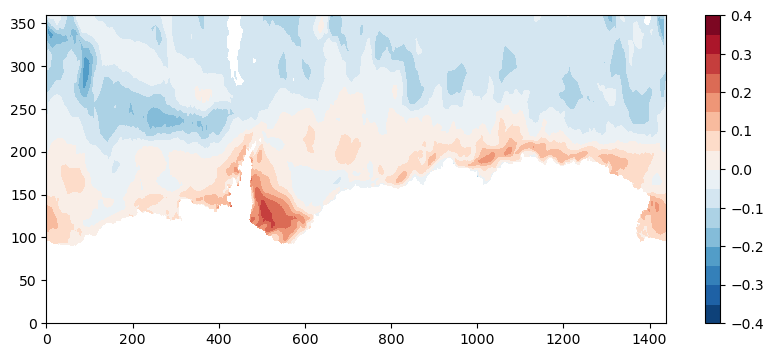

In [46]:
print(which_exp)

print(AGI_1.shape,AGI_2.shape)
#print(AGI_1[0,200,100])
#print(AGI_2[0,200,100])

print(np.min(pO2_2-pO2_1),np.max(pO2_2-pO2_1))

aux1 = AGI_2[0,:,:]-AGI_1[0,:,:]
#print(aux1)

levels1 = np.arange(-0.4,0.4+0.05,0.05)

fig = plt.figure(figsize=(10, 4))
plt.contourf(aux1,levels=levels1,cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.show()

#print(np.min(AGI_1),np.max(AGI_1))
#print(np.min(AGI_2),np.max(AGI_2))


In [47]:
#---
# maps
#---

In [48]:
#----
# define lat/lon -> need to regrid for mapping
#----

grid_resolution_x = 0.1  #0.25 # define grid resolution of regular mesh
grid_resolution_y = 0.1 #0.0625
xi = np.arange(-180,180+grid_resolution_x,grid_resolution_x) #longitude
yi = np.arange(-90,40+grid_resolution_y,grid_resolution_y) #latitude

print ('Min/Max lon:',np.min(xi),np.max(xi))
print ('Min/Max lat:',np.min(yi),np.max(yi))
x_all,y_all = np.meshgrid(xi,yi)

print(x_all.shape)


Min/Max lon: -180.0 179.99999999997954
Min/Max lat: -90.0 39.99999999999261
(1301, 3601)


In [49]:
#----
# plotting function
#-----
from numpy.ma import masked_array

color_cavity = 'black' #'darkgrey'

dpicnt=200
fs = 12
lw = 1.5 # topography
lw2 = 1.0 # cavity

def plot_map_circumpolar(data_plot,lon_plot,lat_plot,habitat_tf,lon_tf,lat_tf,color_tf,topo,levels1,cmap1,ctick1,\
                                    cticks_label,clabel_string,depth_label,\
                         save_plots,display_plots,savepath,filename1):
    plot_colorbar = False
    fs = 10
    
    # data to plot
    data_plot1 = np.copy(data_plot)
   
    # projection
    projection=ccrs.SouthPolarStereo()
    
    plot_MPAs = False
    #color_mpa = (200./255.,200./255.,200./255.) #'white' #'black'
    color_mpa = (160./255.,160./255.,160./255.) #'gold' #'white'
    lw_mpa = 2
    
    path1 = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/masks/masks_MPAs/'
    which_res = '0.025'
    f1 = Dataset(path1+'Mask_cavities_regular_mesh_'+which_res+'deg.nc')
    cav_int = f1.variables['mask_cavities'][:]
    f1.close()
    cav_int[cav_int.mask==True]=0
    f1 = Dataset(path1+'MPA_mask_AntarcticPeninsula_regular_mesh_'+which_res+'deg.nc')
    mask_WAP_MPA = f1.variables['mask_mpa'][:]
    lon_MPA2 = f1.variables['lon'][:]
    lat_MPA2 = f1.variables['lat'][:]
    f1.close()
    lon_MPA,lat_MPA = np.meshgrid(lon_MPA2,lat_MPA2)
    del lon_MPA2,lat_MPA2
    
    if plot_MPAs:

        f1 = Dataset(path1+'MPA_mask_AntarcticPeninsula_regular_mesh_'+which_res+'deg.nc')
        mask_WAP_MPA = f1.variables['mask_mpa'][:]
        lon_MPA2 = f1.variables['lon'][:]
        lat_MPA2 = f1.variables['lat'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_East_Antarctica_1_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA1_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_East_Antarctica_2_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA2_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_East_Antarctica_3_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA3_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_Orkney_regular_mesh_'+which_res+'deg.nc')
        mask_Orkney_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_RossSea_regular_mesh_'+which_res+'deg.nc')
        mask_RossSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_WeddellSea_regular_mesh_'+which_res+'deg.nc')
        mask_WeddellSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()

        mask_eastAA1_MPA[mask_eastAA1_MPA.mask==True]=0 #np.ma.masked_where()
        mask_eastAA2_MPA[mask_eastAA2_MPA.mask==True]=0
        mask_eastAA3_MPA[mask_eastAA3_MPA.mask==True]=0
        mask_WeddellSea_MPA[mask_WeddellSea_MPA.mask==True]=0
        mask_Orkney_MPA[mask_Orkney_MPA.mask==True]=0
        mask_RossSea_MPA[mask_RossSea_MPA.mask==True]=0
        mask_WAP_MPA[mask_WAP_MPA.mask==True]=0
            
        # correct mask so that it matches the mask used on FESOM mesh (see regrid_cavity_to_regular_mesh.ipynb)
        # for the Weddell Sea, connect piece at WAP tip with southern piece
        ind = np.where((lat_MPA<=-64.0) & (lon_MPA<-50) & (lon_MPA>-62.5)) #[0]
        # ind = np.where((lat_MPA<=-64.0) & (lon_MPA<310) & (lon_MPA>298.5)) #[0]
        mask_WeddellSea_MPA[ind]=1
        # correct piece that reaches into WAP
        ind = np.where((lat_MPA>-64.8) & (lon_MPA<-60)) #[0]
        # ind = np.where((lat_MPA >-64.8) & (lon_MPA<300)) #[0]
        mask_WeddellSea_MPA[ind]=0
            
        mask_eastAA1_MPA[cav_int==1]=0
        mask_eastAA2_MPA[cav_int==1]=0
        mask_eastAA3_MPA[cav_int==1]=0
        mask_WeddellSea_MPA[cav_int==1]=0
        mask_Orkney_MPA[cav_int==1]=0
        mask_RossSea_MPA[cav_int==1]=0
        mask_WAP_MPA[cav_int==1]=0
        
        print('min/max mask_MPA:',np.min(mask_WeddellSea_MPA),np.max(mask_WeddellSea_MPA))
        
        
        
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # plot coastal
    mm1=ax.contourf(lon_plot, lat_plot, data_plot1,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    if plot_colorbar:
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.set_label(clabel_string,fontsize=fs+3) #clabel_string
        cbar.ax.tick_params(labelsize=fs+3)
        cbar.ax.set_xticklabels(cticks_label)
        
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                    color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
    gl.top_labels = True
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels=True
    #gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
    gl.ylocator = mticker.FixedLocator([-70,-60,-50]) #[-70,-65,-60,-55,-50]
    #gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.rotate_labels = False

    lw = 2
    ax.contour(lon_plot, lat_plot, topo,levels = [1000],\
                     colors=['dimgrey','black','black'],linewidths=[lw+0.75,lw,lw],\
               linestyles=['-','-',':'],transform=ccrs.PlateCarree())
               
    #-----
    # add MPA contours
    if plot_MPAs:
        #print ('min/max lon_plot:',np.min(lon_plot),np.max(lon_plot))
        #print ('min/max lon_MPA:',np.min(lon_MPA),np.max(lon_MPA))
       
        m = np.zeros_like(mask_RossSea_MPA)
        m[:,0:8] = 1
        m[:,-8:-1] = 1
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        
        m = np.zeros_like(mask_RossSea_MPA)
        m[0:400,:] = 1
        mask_WeddellSea_MPA = np.ma.masked_array(mask_WeddellSea_MPA, m)
        mask_WAP_MPA = np.ma.masked_array(mask_WAP_MPA, m)
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        mask_eastAA1_MPA = np.ma.masked_array(mask_eastAA1_MPA, m)
        mask_eastAA2_MPA = np.ma.masked_array(mask_eastAA2_MPA, m)
        mask_eastAA3_MPA = np.ma.masked_array(mask_eastAA3_MPA, m)
        mask_Orkney_MPA  = np.ma.masked_array(mask_Orkney_MPA, m)
        
        ax.contour(lon_MPA, lat_MPA, mask_WeddellSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_WAP_MPA,levels = [lw_mpa],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_RossSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA1_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA2_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA3_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_Orkney_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        
    ## cavities
    #ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
    #                     colors=['gainsboro'],linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    # cavities
    ind_2 = np.where(lat_plot[:,0]>-75.0)[0]
    cav_int[0:400,:] = 1 # high-high-latitudes
    ind_s = 420
    cav_int[ind_s:,-5] =  -999
    cav_int[ind_s:,-4] =  -999
    cav_int[ind_s:,-3] =  -999
    cav_int[ind_s:,-2] =  -999
    cav_int[ind_s:,-1] =  -999
    cav_int[ind_s:,0]  =  -999
    cav_int[ind_s:,1]  =  -999
    cav_int[ind_s:,2]  =  -999
    cav_int[ind_s:,3]  =  -999
    cav_int[ind_s:,4]  =  -999
    
    m = np.zeros_like(cav_int)
    m[:,0:10] = 1
    m[:,-10:-1] = 1
    cav_int = np.ma.masked_array(cav_int, m)

    cav_color = (50./255.,50./255.,50./255.)
    #cav_color2 = 'oldlace' 
    cav_color2 = (218./255.,228./255.,238./255.)
    
    ax.contourf(lon_MPA, lat_MPA, cav_int,levels = [0.5,1],\
                         colors=[cav_color2],\
               linewidths=[lw],linestyles=['-'],zorder=50,transform=ccrs.PlateCarree())
    
    ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
                         colors=[cav_color],\
               linewidths=[lw],linestyles=['-'],zorder=50,transform=ccrs.PlateCarree())
    
    # add toothfish habitat
    lon_tf2,lat_tf2 = np.meshgrid(lon_tf,lat_tf)
    mm1=ax.contour(lon_tf2,lat_tf2, habitat_tf,levels=[1],colors=[color_tf],linewidths=[0.8],linestyles=['-'],\
                   transform=ccrs.PlateCarree())   
    
    #colors2 = matplotlib.colors.ListedColormap([(218./255.,228./255.,238./255.),(218./255.,228./255.,238./255.),\
    #                                        (218./255.,228./255.,238./255.),(218./255.,228./255.,238./255.)])
    
    #levels1 = np.arange(0,3,1)
    #mm1=ax.contourf(lon_MPA, lat_MPA, cav_int,\
    #           levels=levels1,extend='both',cmap=colors2,transform=ccrs.PlateCarree())
    # gainsboro
    #-----
    
    #ax.contour(lon_plot, lat_plot, data_plot_ice1,levels = [0.15],\
    #                 colors=['black'],linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    #ax.contour(lon_plot, lat_plot, data_plot_ice2,levels = [0.15],\
    #                 colors=['black'],linewidths=[lw],linestyles=['--'],transform=ccrs.PlateCarree())
    #ax.contour(lon_plot, lat_plot, data_plot_ice3,levels = [0.15],\
    #                 colors=['black'],linewidths=[lw],linestyles=[':'],transform=ccrs.PlateCarree())

    #ax.annotate('all between '+str(depth1)+'-'+str(depth2)+'m',xy=(0.29,0.012),\
    #            xycoords='axes fraction',style='italic',fontsize=fs,ha='right',color='k') #fontweight='bold'

    dpicnt = 200

    if save_plots:
        if plot_colorbar:
            filename = filename1+'.png'
        else:
            filename = filename1+'_no_colorbar.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    #return lon_MPA, lat_MPA,cav_int
        
def plot_map_circumpolar_colorbar(data_plot,lon_plot,lat_plot,topo,levels1,cmap1,cticks1,\
                                    cticks_label,clabel_string,depth_label,\
                         save_plots,display_plots,savepath,filename1):
    plot_colorbar = True
    fs = 10
    
    # data to plot
    data_plot1 = np.copy(data_plot)
   
    # projection
    projection=ccrs.SouthPolarStereo()
    
    #---
    # PNG
    #---
    print('Colorbar png...')
    fig = plt.figure(figsize=(10, 9))
    mm1 = plt.contourf(lon_plot, lat_plot, data_plot,levels=levels1,extend='both',cmap=cmap1)
    
   # ax = fig.add_subplot(1, 1, 1, projection=projection)
   # ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
   # ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
   # ax.coastlines(resolution='50m')
   # # Compute a circle in axes coordinates, which we can use as a boundary
   # # for the map. We can pan/zoom as much as we like - the boundary will be
   # # permanently circular.
   # theta = np.linspace(0, 2*np.pi, 100)
   # center, radius = [0.5, 0.5], 0.5
   # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
   # circle = mpath.Path(verts * radius + center)
   # ax.set_boundary(circle, transform=ax.transAxes)
    
  #  # plot coastal
  #  #data_plot1 = np.ones_like(lon_plot)
  #  mm1=ax.contourf(lon_plot, lat_plot, data_plot,\
  #                 levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    plt.gca().set_visible(False)
    if plot_colorbar:
        #cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar = plt.colorbar(mm1,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.set_label(clabel_string,fontsize=fs+3) #clabel_string
        cbar.ax.tick_params(labelsize=fs+3)
        cbar.ax.set_xticklabels(cticks_label)

    dpicnt = 200
    if save_plots:
        filename = filename1+'.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    #---
    # EPS
    #---
    print('Colorbar eps...')
    fig = plt.figure(figsize=(10, 9))
    mm1 = plt.contourf(lon_plot, lat_plot, data_plot,levels=levels1,extend='both',cmap=cmap1)
    
   # ax = fig.add_subplot(1, 1, 1, projection=projection)
   # ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
   # ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
   # ax.coastlines(resolution='50m')
   # # Compute a circle in axes coordinates, which we can use as a boundary
   # # for the map. We can pan/zoom as much as we like - the boundary will be
   # # permanently circular.
   # theta = np.linspace(0, 2*np.pi, 100)
   # center, radius = [0.5, 0.5], 0.5
   # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
   # circle = mpath.Path(verts * radius + center)
   # ax.set_boundary(circle, transform=ax.transAxes)
   # mm1=ax.contourf(lon_plot, lat_plot, data_plot,\
   #                levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    plt.gca().set_visible(False)
    if plot_colorbar:
        #cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar = plt.colorbar(mm1,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        #cbar.set_label(clabel_string,fontsize=fs+3) #clabel_string
        cbar.ax.tick_params(labelsize=fs+3)
        cbar.ax.set_xticklabels([])#cticks_label)

    dpicnt = 200
    if save_plots:
        filename = filename1+'.eps'
        plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
    
        
        

In [50]:

year_list2 = np.arange(2090,2099+1,1)

for yy in range(0,1):
    year2 = year_list2[yy]
    print('Load year ',year2)
    
    # pO2 data (mbar)
    file_pO2  = path2+'/pO2_fesom_simA'+which_sim+'_'+str(year2)+'0101_v2.nc'
    data_pO2   = xr.open_dataset(file_pO2)
    if yy==0:
        print('Load depth levels')
        depths = data_pO2['depth'].values
        lat_data = data_pO2['lat'].values
        lon_data = data_pO2['lon'].values
        
print(lat_data.shape,lon_data.shape)


Load year  2090
Load depth levels
(360,) (1440,)


In [51]:
#---
# get toothfish habitat
#---

basepath="/pscratch/sd/c/cnissen/AGI_toothfish_project/" 
no_species=29

# Init
species_names         = [None] * no_species # empty list
species_names_        = [None] * no_species # empty list
habitat_file_names    = [None] * no_species # empty list
habitat_all = np.zeros([360,1440,no_species])

habitat_files = Path(basepath + "all_prey_plus_toothfish/").glob('*_boolean.nc')  # updated habitat files, Nov 2022!!!!!!
#habitat_files = Path(basepath + "share/").glob('*_boolean.nc') 
# Note: I changed name of file of Antimora_rostrata to *boolean2.nc, so that it won't be included here
for ifile,file in enumerate(habitat_files):   
    habitat_file_names[ifile]    = str(file)
    
    ff = xr.open_dataset(file)
    habitat_all[:,:,ifile] = ff['presence'].values 
    if ifile==0:
        lat  = ff['lat'].values 
        lon  = ff['lon'].values 
    ff.close()

    # Get the species name from the full pathname with a space between
    species_names[ifile]  = '_'.join(os.path.basename(file).split('_')[:-2]).replace('_',' ') 
    if not species_names[ifile] in ['Galiteuthis glacialis','Mesonychoteuthis hamiltoni','Kondakovia longimana']:
        species_names[ifile] = species_names[ifile][8:] # get rid of "Default" or "Reviewed"
    if species_names[ifile][0].isspace():  # get rid of white space if there is any
        species_names[ifile] = species_names[ifile][1:]
    if species_names[ifile] in ['Chionobathyscus dewitti All Suitable Habitat']:
        species_names[ifile] = species_names[ifile][0:23]
    # Get the species name from the full pathname with _ in it
    species_names_[ifile] = species_names[ifile].replace(' ','_')  #'_'.join(os.path.basename(file).split('_')[:-2]) 

#print(habitat_file_names)
print(species_names)
print(len(species_names),'species')
print(species_names_)

# for plotting, set regions outside of habitat to negative number (so that they appear in white)
habitat_all[habitat_all==0] = -999

habitat_tf = habitat_all[:,:,0]
print(habitat_tf.shape)


['Dissostichus mawsoni', 'Trematomus loennbergii', 'Macrourus whitsoni', 'Galiteuthis glacialis', 'Chionodraco hamatus', 'Anotopterus vorax', 'Chaenodraco wilsoni', 'Kondakovia longimana', 'Cryodraco antarcticus', 'Muraenolepis microps', 'Psychroteuthis glacialis', 'Gymnodraco acuticeps', 'Amblyraja georgiana', 'Antarctomysis maxima', 'Lepidonotothen squamifrons', 'Mesonychoteuthis hamiltoni', 'Pleuragramma antarctica', 'Euphausia superba', 'Notothenia coriiceps', 'Trematomus lepidorhinus', 'Pagothenia borchgrevinki', 'Lycenchelys aratrirostris', 'Neopagetopsis ionah', 'Chaenocephalus aceratus', 'Trematomus hansoni', 'Chionobathyscus dewitti', 'Euphausia crystallorophias', 'Notothenia rossii', 'Bathyraja maccaini']
29 species
['Dissostichus_mawsoni', 'Trematomus_loennbergii', 'Macrourus_whitsoni', 'Galiteuthis_glacialis', 'Chionodraco_hamatus', 'Anotopterus_vorax', 'Chaenodraco_wilsoni', 'Kondakovia_longimana', 'Cryodraco_antarcticus', 'Muraenolepis_microps', 'Psychroteuthis_glacialis'

1995-2014
2091-2100
2091-2100 minus 1995-2014 2091-2100 vs 1995-2014
regrid topo
regrid cavity info


_Temp_historical

get average field between 0m and 400m


100%|██████████| 360/360 [01:08<00:00,  5.29it/s]


Min/max total_depth: 203.5 391.0
Min/max AGI 1995-2014: -1680.0149486462158 91.36486250345537
Min/max AGI 2091-2100: -178.76455580631816 18.11765653467594

regrid field between 0m and 400m
regrid 1995-2014
regrid 2091-2100
Min/Max 1995-2014: -1872.7916969768123 244.23495391138056
Min/Max 2091-2100 1: -184.53257213844142 24.52219874016199

plot 1995-2014...
Min/Max data_plot: -1872.7916969768123 244.23495391138056


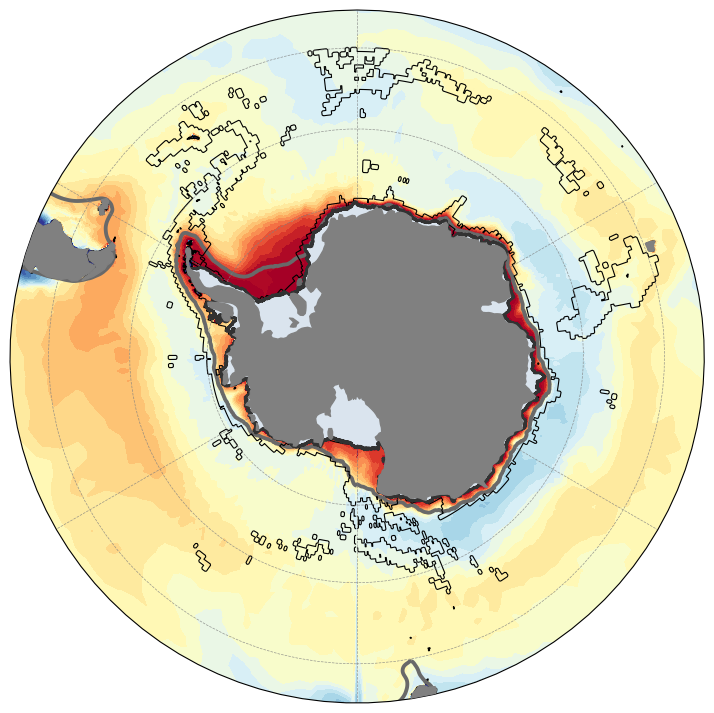

Colorbar png...


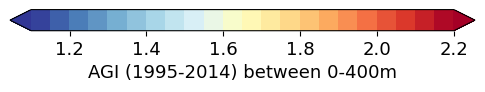

Colorbar eps...


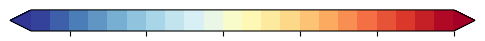

Plot ssp585
Plot absolute change...
Map_AGI_ssp585_2091-2100_minus_1995-2014_depth_interval_between_0m_400m_Temp_historical
-999.0 36.39309395794088


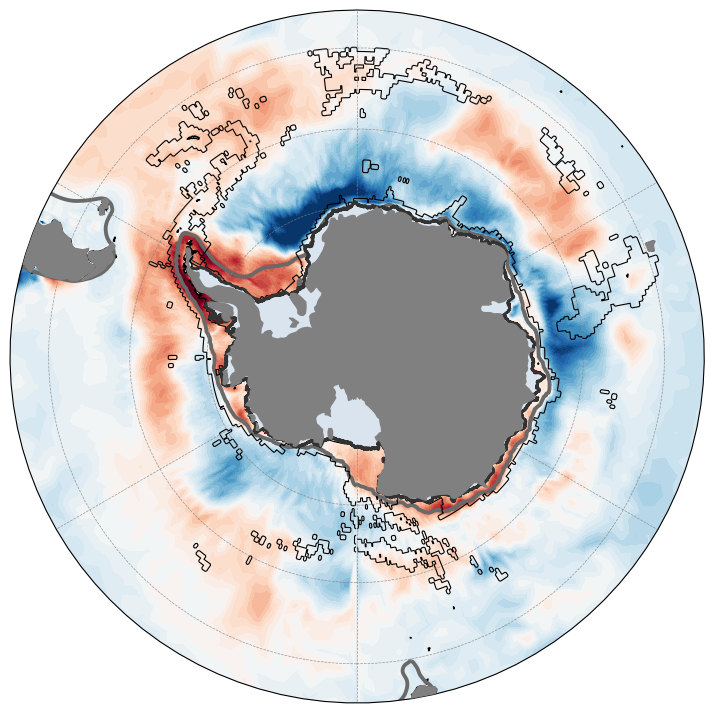

Colorbar png...


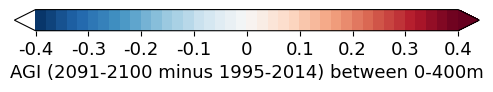

Colorbar eps...


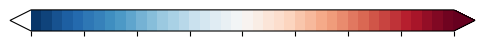

Plot relative change...
Map_AGI_ssp585_2091-2100_vs_1995-2014_relative_change_depth_interval_between_0m_400m_Temp_historical
-999.0 79.91440329108974


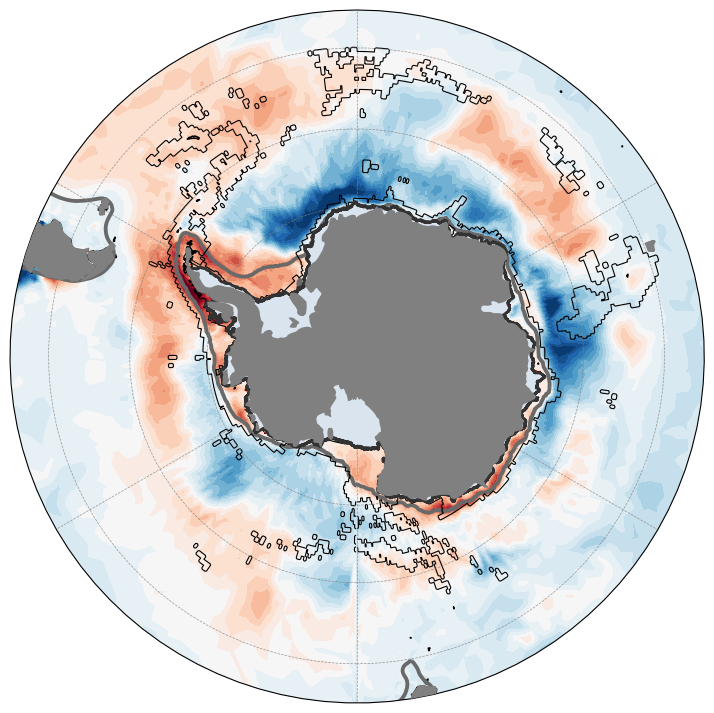

Colorbar png...


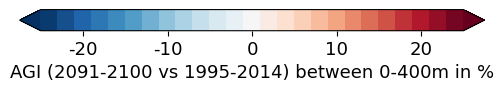

Colorbar eps...


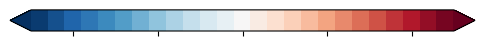



_Temp_historical

get average field between 400m and 700m


100%|██████████| 360/360 [00:59<00:00,  6.07it/s]


Min/max total_depth: 20.20001220703125 308.0
Min/max AGI 1995-2014: -68.79913712701492 551.288595565677
Min/max AGI 2091-2100: 0.0 78.34285602188214

regrid field between 400m and 700m
regrid 1995-2014
regrid 2091-2100
Min/Max 1995-2014: -67.33283968789583 523.519095191124
Min/Max 2091-2100 1: -8.955477639173498 71.70370497274128

plot 1995-2014...
Min/Max data_plot: -999.0 523.519095191124


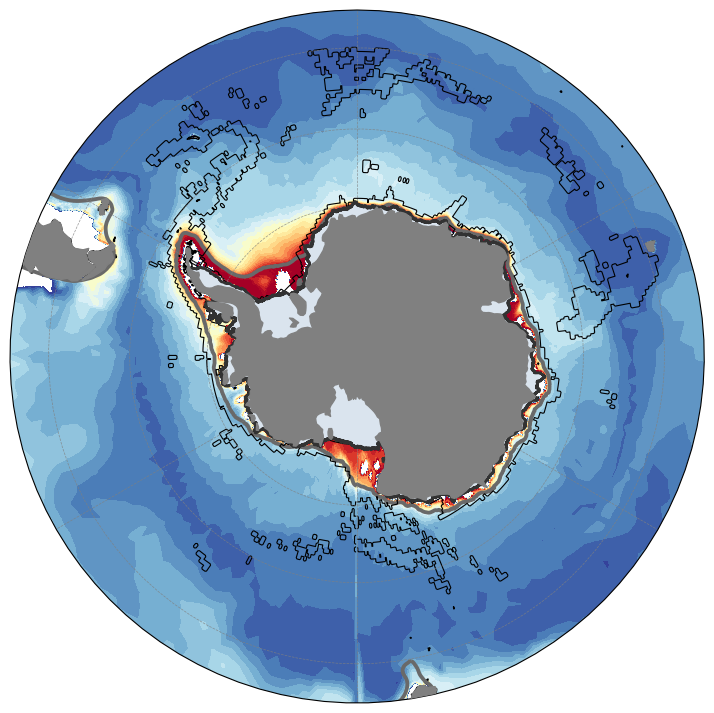

Plot ssp585
Plot absolute change...
Map_AGI_ssp585_2091-2100_minus_1995-2014_depth_interval_between_400m_700m_Temp_historical
-999.0 46.32766112561541


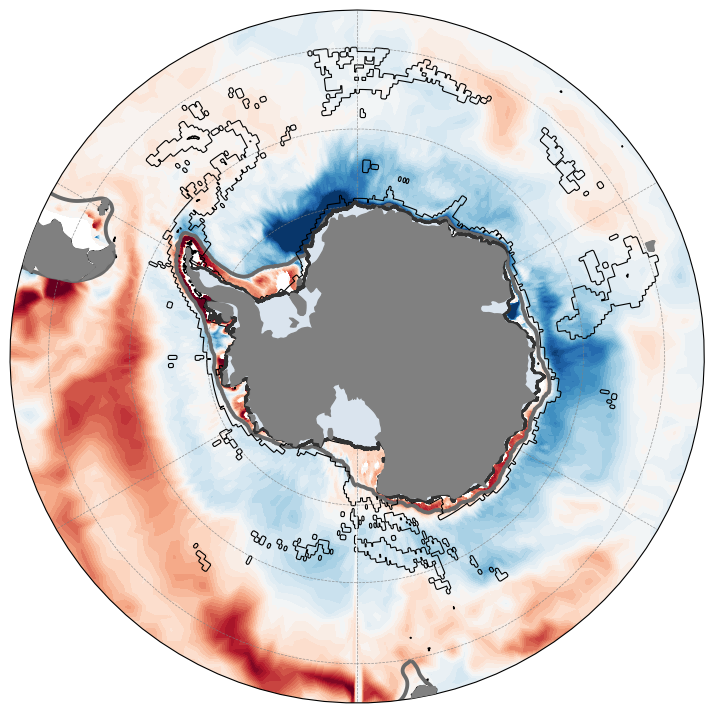

Plot relative change...
Map_AGI_ssp585_2091-2100_vs_1995-2014_relative_change_depth_interval_between_400m_700m_Temp_historical
-999.0 73.08866608843152


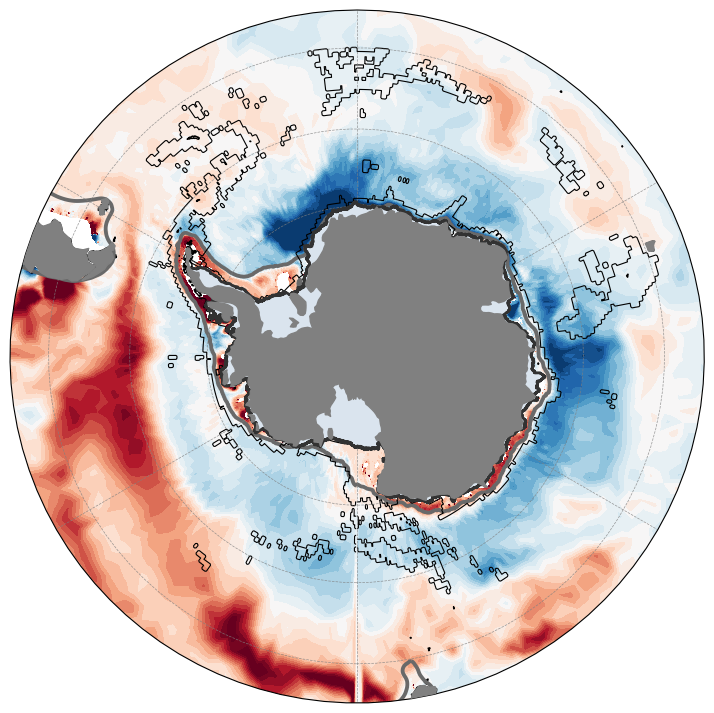



_Temp_historical

get average field between 700m and 1000m


100%|██████████| 360/360 [00:51<00:00,  6.94it/s]


Min/max total_depth: 21.20001220703125 278.29998779296875
Min/max AGI 1995-2014: 0.0 13.7180059684193
Min/max AGI 2091-2100: 0.0 13.788000830742584

regrid field between 700m and 1000m
regrid 1995-2014
regrid 2091-2100
Min/Max 1995-2014: -1.6311217933788016 11.447124505718156
Min/Max 2091-2100 1: -1.6408244858476109 11.503199697663117

plot 1995-2014...
Min/Max data_plot: -999.0 11.447124505718156


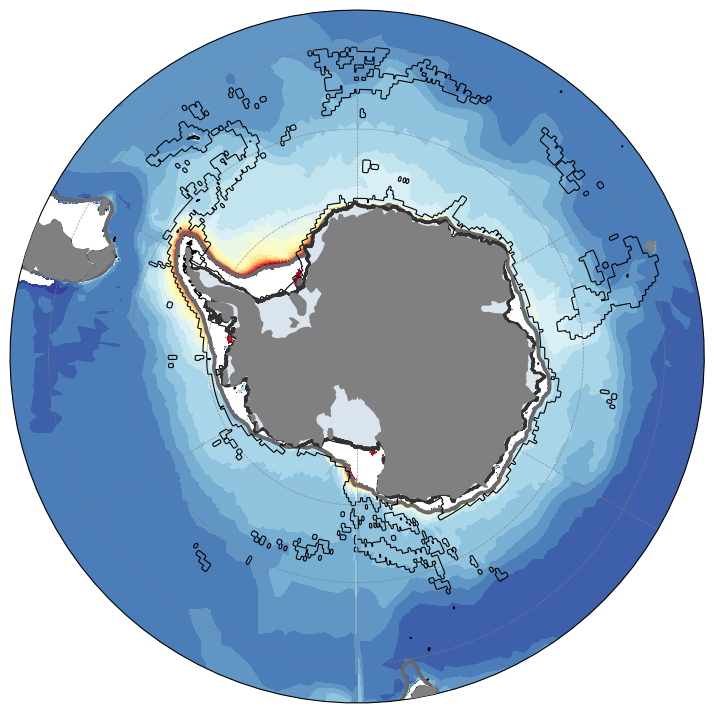

Plot ssp585
Plot absolute change...
Map_AGI_ssp585_2091-2100_minus_1995-2014_depth_interval_between_700m_1000m_Temp_historical
-999.0 0.7934187553345673


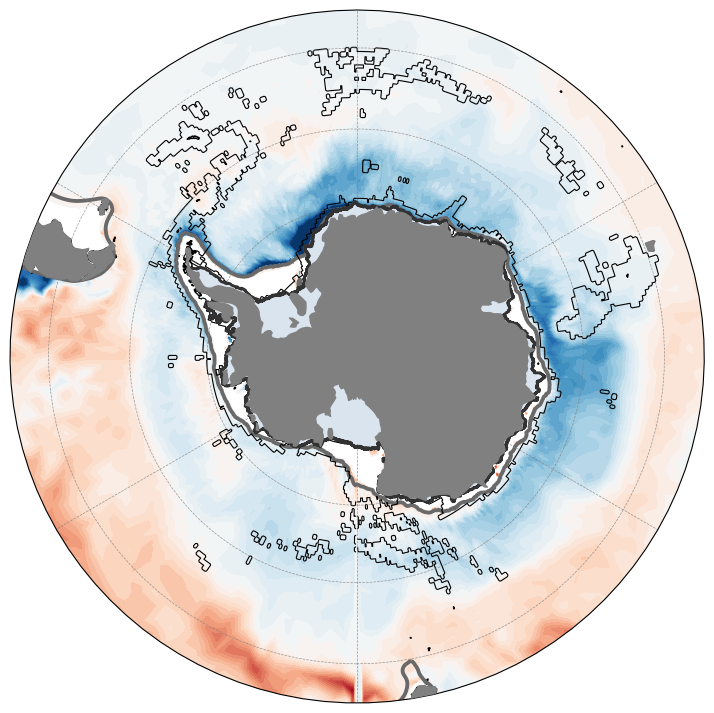

Plot relative change...
Map_AGI_ssp585_2091-2100_vs_1995-2014_relative_change_depth_interval_between_700m_1000m_Temp_historical
-999.0 10.827638098358342


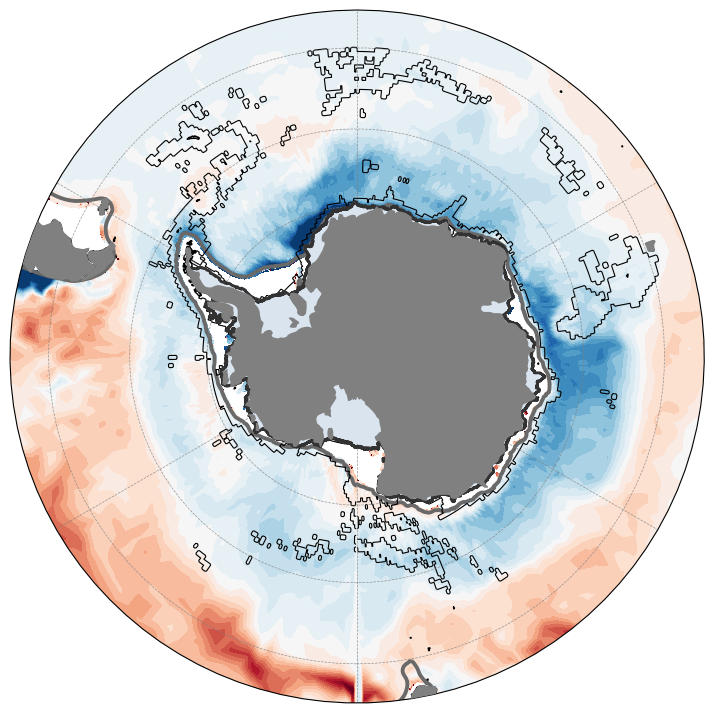



_Temp_historical

get average field between 1000m and 3500m


100%|██████████| 360/360 [00:48<00:00,  7.45it/s] 


Min/max total_depth: 28.0 2243.300048828125
Min/max AGI 1995-2014: 0.0 2.566904424151609
Min/max AGI 2091-2100: 0.0 2.7595595401090813

regrid field between 1000m and 3500m
regrid 1995-2014
regrid 2091-2100
Min/Max 1995-2014: -0.5411475010894273 3.0626124761875007
Min/Max 2091-2100 1: -0.5886848533749455 3.238162252406119

plot 1995-2014...
Min/Max data_plot: -999.0 3.0626124761875007


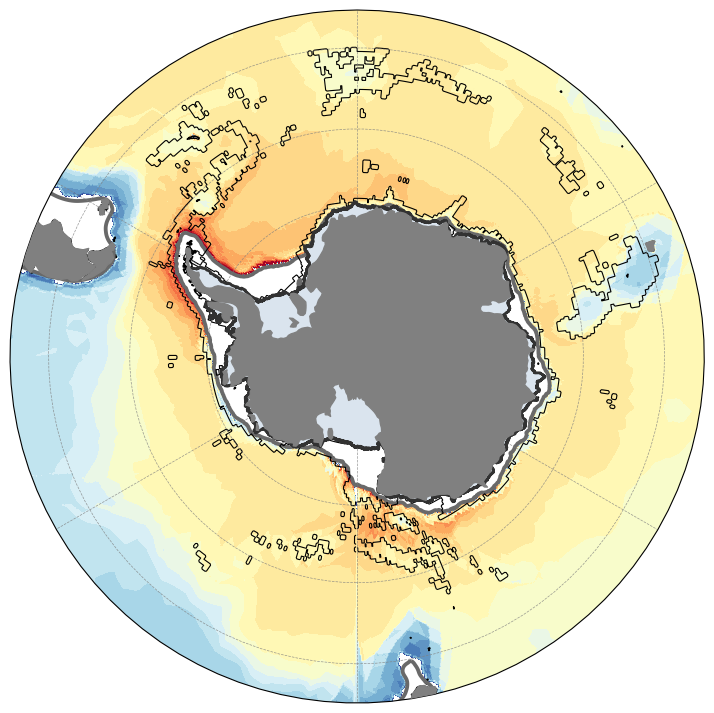

Plot ssp585
Plot absolute change...
Map_AGI_ssp585_2091-2100_minus_1995-2014_depth_interval_between_1000m_3500m_Temp_historical
-999.0 0.19094677081290046


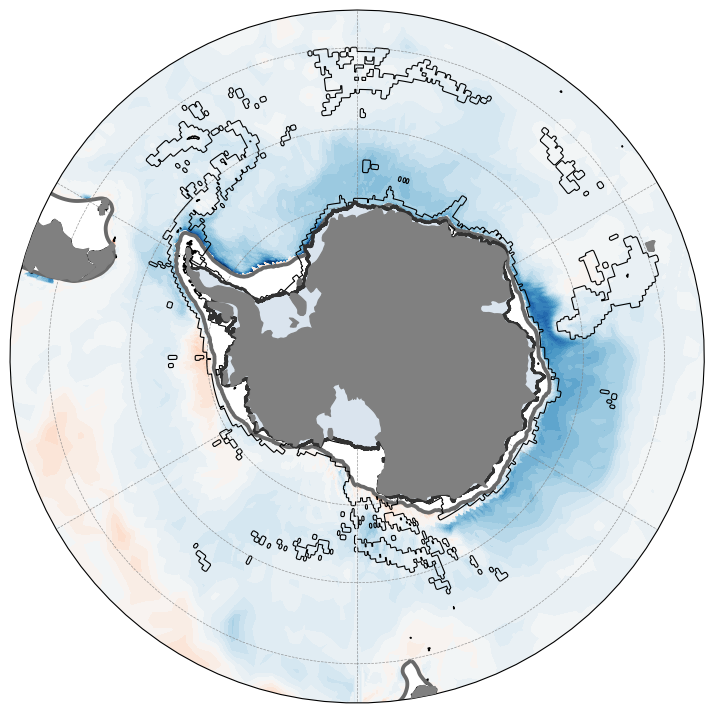

Plot relative change...
Map_AGI_ssp585_2091-2100_vs_1995-2014_relative_change_depth_interval_between_1000m_3500m_Temp_historical
-999.0 76.16464278870008


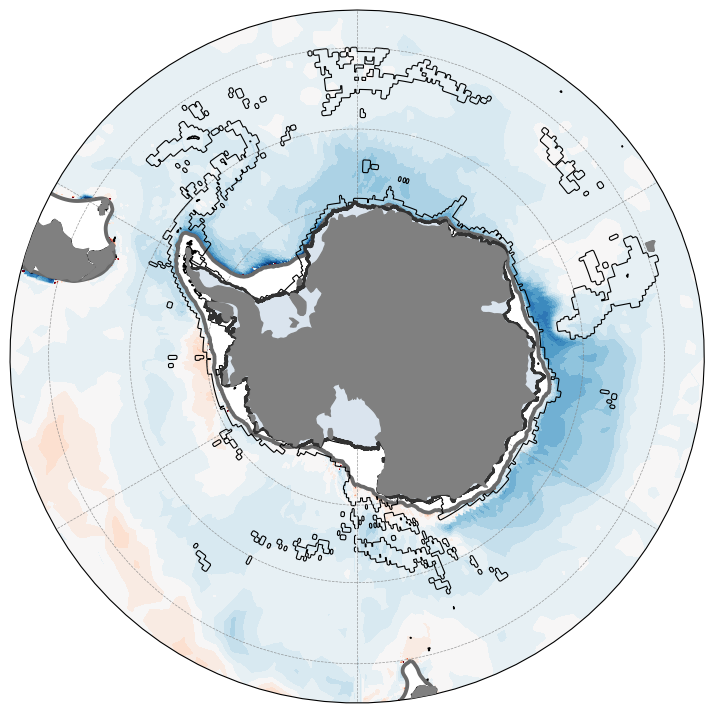

done


In [52]:
####
# 1) get average over current depth interval
# 2) interpolate
# 3) plot each depth interval
from tqdm import tqdm
from cartopy.util import add_cyclic_point

lat_orig,lon_orig   = lat_model,lon_model #mesh.y2, mesh.x2
lat_orig2,lon_orig2 = lat_data,lon_data
lat_orig2,lon_orig2 = np.meshgrid(lat_orig2,lon_orig2)

save_plots = True
display_plots = True

to_plot_1990s      = True
to_plot_abs_change = True
to_plot_rel_change = True 

time_String_hist       = '1995-2014'
time_String_future     = str(int(which_drift[0:4]))+'-'+str(int(which_drift[5:]))
time_String_diff       = str(int(which_drift[0:4]))+'-'+str(int(which_drift[5:]))+' minus 1995-2014'
time_String_diff_ratio = str(int(which_drift[0:4]))+'-'+str(int(which_drift[5:]))+' vs 1995-2014'
print(time_String_hist)
print(time_String_future)
print(time_String_diff,time_String_diff_ratio)

depths = np.copy(zlevs)

def interpolate_fields(lat_orig,lon_orig,data,lat_final,lon_final):
    interp_method = 'cubic' # cubic, nearest, linear
    data_int = griddata((lon_orig,lat_orig),data,\
                (lon_final.ravel(), lat_final.ravel()), method=interp_method)  # Final interpolated field
    data_int = data_int.reshape((lon_final.shape[0],lon_final.shape[1])) 
    return data_int
    
#---------
print ('regrid topo')
topo_int = interpolate_fields(lat_model,lon_model,topo,y_all,x_all)
#--------
print ('regrid cavity info')
cav_int = interpolate_fields(lat_model,lon_model,cavities,y_all,x_all)
#--------

# second version of depth intervals (motivated by temp & O2 changes in toothfish habitat)
depth_list1 = [0,   0,  400,700, 1000]
depth_list2 = [3500,400,700,1000,3500]

data_avg_1990s   = np.zeros([len(depth_list1),len(lat_data),len(lon_data)])
data_avg_2090s_1 = np.zeros([len(depth_list1),len(lat_data),len(lon_data)])
for dd in range(1,len(depth_list1)):
    print('')
    print()
    print(which_exp)
    print()
    print('get average field between '+str(depth_list1[dd])+'m and '+str(depth_list2[dd])+'m')
    ind_dd = np.where((zlevs>=depth_list1[dd]) & (zlevs<depth_list2[dd]))[0]
    
    if depth_list1[dd]==0:
        # since zlevs are at the bottom of the cell, exclude zero here
        #dz = np.diff(zlevs[ind_dd])
        aux1 = np.copy(AGI_1)[ind_dd,:,:]
        aux2 = np.copy(AGI_2)[ind_dd,:,:]
    else:
        if depth_list2[dd]==3500:
            # for some reason, the code did not work if ind_dd contained 88... (why did it work before? CHECK)
            #dz = np.diff(zlevs[np.hstack((ind_dd[0]-1,ind_dd[:-1]))]) 
            aux1 = np.copy(AGI_1)[ind_dd[:-1],:,:] #
            aux2 = np.copy(AGI_2)[ind_dd[:-1],:,:]
        else:
            # add one before first index to correctly account for first depth level
            # (zlevs are at the bottom of the cell)
            #dz = np.diff(zlevs[np.hstack((ind_dd[0]-1,ind_dd))]) 
            aux1 = np.copy(AGI_1)[ind_dd,:,:]
            aux2 = np.copy(AGI_2)[ind_dd,:,:]
    aux2[aux2<-9] = np.nan # for some reason, aux2 has "-99" in the array... correct here so that different plots look ok
    
                
    # loop over all locations to create array with correct total_depth
    total_depth_all = np.zeros([aux1.shape[1],aux1.shape[2]])
    for mm in tqdm(range(0,aux1.shape[1])): #[100]: #range(0,aux1.shape[1]):
        for nn in range(0,aux1.shape[2]): #[500]: #range(0,aux1.shape[2]):
            aux1b = aux1[:,mm,nn] # no need to also define aux2b -> NaNs in the vertical are identical across time slices
            ind_av = np.where(~np.isnan(aux1b))[0]  
          #  print(aux1b.shape,aux1b)
          #  print(ind_av.shape,ind_av)
            if len(ind_av)>0: # only continue if any depth levels are available
                if depth_list1[dd]==0:
                    # CAREFULLY CHECK THIS!!!
                    if zlevs[ind_dd[ind_av]][0]>0:
                        # added for the case that only depth levels at the subsurface are available
                        dz = np.diff(zlevs[np.hstack((ind_dd[0]-1,ind_dd[ind_av]))]) 
                    else:
                        dz = np.diff(zlevs[np.hstack((0,ind_dd[ind_av]))]) # add an extra zero here so that field at 0m is not included
                        #dz = np.diff(zlevs[ind_dd[ind_av]])  
                else:
                    if depth_list2[dd]==3500:
                        dz = np.diff(zlevs[np.hstack((ind_dd[0]-1,ind_dd[:-1][ind_av]))]) 
                    else:
                        dz = np.diff(zlevs[np.hstack((ind_dd[0]-1,ind_dd[ind_av]))]) 
                #print(np.sum(dz),dz)
            
                # multiply AGI array with dz already
                aux1[ind_av,mm,nn] = aux1[ind_av,mm,nn]*np.abs(dz)
                aux2[ind_av,mm,nn] = aux2[ind_av,mm,nn]*np.abs(dz)
             
           #     print(dz.shape,dz)
                total_depth_all[mm,nn] = np.sum(dz)
            
    aux1 = np.ma.masked_where(aux1==0,aux1)
    aux2 = np.ma.masked_where(aux2==0,aux2)
    
    print('Min/max total_depth:',np.min(total_depth_all[total_depth_all>0]),np.max(total_depth_all))
    
    # AGI array has already been multiplied with dz above, simply sum up here and divide by the total depth
    data_avg_1990s[dd,:,:] = np.nansum(aux1,axis=0)/total_depth_all
    data_avg_2090s_1[dd,:,:] = np.nansum(aux2,axis=0)/total_depth_all
    
    print('Min/max AGI '+time_String_hist+':',np.min(data_avg_1990s[dd,:,:]),np.max(data_avg_1990s[dd,:,:]))
    print('Min/max AGI '+time_String_future+':',np.min(data_avg_2090s_1[dd,:,:]),np.max(data_avg_2090s_1[dd,:,:]))

    
    data_avg_1990s[np.isnan(data_avg_1990s)] = 0
    data_avg_2090s_1[np.isnan(data_avg_2090s_1)] = 0

    #-----
    # regrid and plot (strictly speaking, the regridding is not necessary for plotting -> fields are already on a regular grid)
    # I do it anyways because the plotting function currently expects topo, cavity info and  and data to be on the same grid
    #-----
    print('')
    print('regrid field between '+str(depth_list1[dd])+'m and '+str(depth_list2[dd])+'m')
    
    #--------
    print('regrid '+time_String_hist)
    data_1990s_int = interpolate_fields(lat_orig2.ravel(),lon_orig2.ravel(),\
                                        data_avg_1990s[dd,:,:].transpose().ravel(), y_all,x_all)
    print('regrid '+time_String_future)
    data_2090s_1_int = interpolate_fields(lat_orig2.ravel(),lon_orig2.ravel(),\
                                          data_avg_2090s_1[dd,:,:].transpose().ravel(), y_all,x_all)
    print('Min/Max '+time_String_hist+':',np.nanmin(data_1990s_int),np.nanmax(data_1990s_int))
    print('Min/Max '+time_String_future+' 1:',np.nanmin(data_2090s_1_int),np.nanmax(data_2090s_1_int))    
    
    #----
    # prepare data to plot
    #----
    data_topo = np.copy(topo_int)
    data_cav = np.copy(cav_int)

    # topo & sea ice
    def correct_dateline_points(data):
        # for topo & sea ice: correct a few more longitudes to get smooth contour lines across the dateline
        data[:,3] = data[:,4]
        data[:,2] = data[:,3]
        data[:,1] = data[:,2]
        data[:,0] = data[:,1]
        data[:,-4] = data[:,-5]
        data[:,-3] = data[:,-4]
        data[:,-2] = data[:,-3]
        data[:,-1] = data[:,-2]
        return data

    data_topo = correct_dateline_points(data_topo)

    data_cav[:,1] = data_cav[:,2]
    data_cav[:,0] = data_cav[:,1]
    data_cav[:,-2] = data_cav[:,-3]
    data_cav[:,-1] = data_cav[:,-2]

    data_1990s_int, lon   = add_cyclic_point(data_1990s_int, coord=xi)
    data_2090s_1_int, lon = add_cyclic_point(data_2090s_1_int, coord=xi)
    lon_plot,lat_plot = np.meshgrid(lon,yi) 

    data2, lonxx = add_cyclic_point(data_topo, coord=xi)
    del lonxx
    data3, lonxx = add_cyclic_point(data_cav, coord=xi)
    del lonxx
    #print (data2.shape)
    #print (data3.shape)

    #----
    # correct data in cavity etc
    #----
    # correct topo data on land
    data2[data2<0]=-999
    data2[np.isnan(data2)]=-999

    # cavity field
    data3[data3<0]=-999
    data3[np.isnan(data3)]=-999

    data2[data3>=0.5]=-999
    
    cmap1 = copy.copy(plt.cm.RdBu_r)
    cmap1.set_under('white')
    cmap2 = copy.copy(plt.cm.RdYlBu_r)
    if depth_list1[dd]>0:
        cmap2.set_under('white')
    cmap3 = copy.copy(plt.cm.RdBu_r) # without the white
    cmap4 = copy.copy(plt.cm.Reds)
    cmap4.set_under('white')
    
    #---
    # plot 1990s     
    #----
    print('')
    print ('plot '+time_String_hist+'...')
    
    # historical
    levels1a = np.arange(1.1,2.2+0.05,0.05) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
    cticks1 = [1.2,1.4,1.6,1.8,2.0,2.2]
    cticks_label = [1.2,1.4,1.6,1.8,2.0,2.2]
    
    # 1990s (used to mask missing data for difference plot)
    data_plot = np.copy(data_1990s_int) #data_plot_2090s_bottom-data_plot_1990s_bottom)
    if depth_list1[dd]>0: 
        data_plot[data_plot==0]=999
        data_plot[np.isnan(data_plot)]=999
        data_plot[data_plot<=levels1a[0]] = levels1a[0]
        data_plot[data_plot==999]=-999
    else:
        data_plot = np.ma.masked_where(data_plot==0,data_plot)
        data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
    print('Min/Max data_plot:',np.min(data_plot),np.max(data_plot))
        
    data_plot[:,0] = data_plot[:,2]
    data_plot[:,1] = data_plot[:,2]
    data_plot[:,-1] = data_plot[:,0]
    data_plot[:,-2] = data_plot[:,0]
    data_plot[data2<=depth_list1[dd]]=-999
    #data_plot[data_plot.mask==True] = -999 
    
    clabel_string = 'AGI ('+time_String_hist+') between '+str(depth_list1[dd])+'-'+str(depth_list2[dd])+'m'
    depth_label = 'XX'
    filename = 'Map_AGI_'+time_String_hist+'_depth_interval_between_'+\
                        str(depth_list1[dd])+'m_'+str(depth_list2[dd])+'m'
    if to_plot_1990s:
        color_tf = 'black'
        plot_map_circumpolar(data_plot,lon_plot,lat_plot,habitat_tf,lon_data,lat_data,color_tf,data2,\
                             levels1a,cmap2,cticks1,cticks_label,clabel_string,depth_label,\
                                        save_plots,display_plots,savepath,filename)
        if (dd==1):
            filename = 'Map_AGI_'+time_String_hist+'_COLORBAR' 
            plot_map_circumpolar_colorbar(data_plot,lon_plot,lat_plot,data2,\
                             levels1a,cmap2,cticks1,cticks_label,clabel_string,depth_label,\
                                        save_plots,display_plots,savepath,filename)
    
    test_plot = False
    if test_plot:
        ind_lat = np.where(lat_plot[:,0]<=-45)[0]
        fig = plt.figure(figsize=(10, 5))
        plt.contourf(lon_plot[ind_lat,:],lat_plot[ind_lat,:],data_plot[ind_lat,:],levels=levels1a)
        plt.colorbar()
        plt.show()

    #----
    # PLOT FUTURE SCENARIO
    #----
    
    ## absolute change
    #levels1a = np.arange(-0.4,0.4+0.02,0.02) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
    #cticks1 = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
    #cticks_label = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
    
    # absolute change
    levels1a = np.arange(-0.4,0.4+0.02,0.02) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
    cticks1 = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
    cticks_label = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
    
    # relative change
    #if which_exp in ['_O2_historical']:
    #    levels1b = np.arange(1.4,2.1+0.025,0.025) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
    #    cticks2 = [1.4,1.6,1.8,2.0]
    #    cticks_label2 = [1.4,1.6,1.8,2.0]
    #else:
    #    levels1b = np.arange(0.7,1.3+0.025,0.025) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
    #    cticks2 = [0.7,0.8,0.9,1,1.1,1.2,1.3]
    #    cticks_label2 = [0.7,0.8,0.9,1,1.1,1.2,1.3]
        
    #levels1b = np.arange(0.85,1.15+0.02,0.02) 
    #cticks2 = [0.85,0.9,0.95,1,1.05,1.1,1.15]
    #cticks_label2 = [0.85,0.9,0.95,1,1.05,1.1,1.15]
    
    levels1b = np.arange(0.75,1.25+0.02,0.02) 
    cticks2 = [0.8,0.9,1,1.1,1.2]
    cticks_label2 = [-20,-10,0,10,20] # 0.8,0.9,1,1.1,1.2
        
    for ss in range(0,1):#len(sim_list)):
        which_scenario = which_sim #sim_list[ss]
        print('Plot',which_scenario)
        
        #---
        # absolute change
        #---
        print('Plot absolute change...')
        aux_data_2090s = np.copy(data_2090s_1_int)
        data_plot2 = np.copy(aux_data_2090s - data_1990s_int) #data_plot_2090s_bottom-data_plot_1990s_bottom)
        data_plot2[data_plot2<levels1a[0]] = levels1a[0]+0.01
        del aux_data_2090s

        data_plot2[:,0] = data_plot2[:,2]
        data_plot2[:,1] = data_plot2[:,2]
        data_plot2[:,-1] = data_plot2[:,0]
        data_plot2[:,-2] = data_plot2[:,0]
        data_plot2[data2<depth_list1[dd]] = -999 
        
        #data_plot2[data_plot.mask==True] = -999 

        clabel_string = 'AGI ('+time_String_diff+') between '+str(depth_list1[dd])+'-'+str(depth_list2[dd])+'m'
        depth_label = 'XX'
        filename = 'Map_AGI_'+which_scenario+'_'+time_String_diff.replace(" ","_")+'_depth_interval_between_'+\
                        str(depth_list1[dd])+'m_'+str(depth_list2[dd])+'m'+which_exp      
        print(filename)
        print(np.nanmin(data_plot2),np.nanmax(data_plot2))

        if to_plot_abs_change:
            color_tf = 'black'
            plot_map_circumpolar(data_plot2,lon_plot,lat_plot,habitat_tf,lon_data,lat_data,color_tf,data2,\
                                 levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                            save_plots,display_plots,savepath,filename)
            if (dd==1) & (ss==0):
                filename = 'Map_AGI_'+time_String_diff.replace(" ","_")+'_COLORBAR' 
                plot_map_circumpolar_colorbar(data_plot2,lon_plot,lat_plot,data2,\
                                 levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                            save_plots,display_plots,savepath,filename)
                
        #---
        # relative change
        #---
        print('Plot relative change...')
        aux_data_2090s = np.copy(data_2090s_1_int)
        data_plot2 = np.copy(aux_data_2090s/data_1990s_int) #data_plot_2090s_bottom-data_plot_1990s_bottom)
        data_plot2[data_plot2<levels1b[0]] = levels1b[0]+0.01
        #data_plot2[data_plot<0]=-999
        del aux_data_2090s
        
        data_plot2[data2<depth_list1[dd]] = -999 
        data_plot2[np.isnan(data_plot2)] = -999

        data_plot2[:,0] = data_plot2[:,2]
        data_plot2[:,1] = data_plot2[:,2]
        data_plot2[:,-1] = data_plot2[:,0]
        data_plot2[:,-2] = data_plot2[:,0]

        #data_plot2[data_plot.mask==True] = -999 

        clabel_string = 'AGI ('+time_String_diff_ratio+') between '+str(depth_list1[dd])+'-'+str(depth_list2[dd])+'m in %'
        depth_label = 'XX'
        filename = 'Map_AGI_'+which_scenario+'_'+time_String_diff_ratio.replace(" ","_")+'_relative_change_depth_interval_between_'+\
                        str(depth_list1[dd])+'m_'+str(depth_list2[dd])+'m'+which_exp 
        print(filename)
        
        data_plot2[data_plot2>100]=-999
        data_plot2[data2<=depth_list1[dd]]=-999
        print(np.nanmin(data_plot2),np.nanmax(data_plot2))
        
        if to_plot_rel_change:
            if which_exp in ['_O2_historical']:
                #data_plot2[data_plot2>levels1b[-1]] = levels1b[-1]
                color_tf = 'black'
                plot_map_circumpolar(data_plot2,lon_plot,lat_plot,habitat_tf,lon_data,lat_data,color_tf,data2,\
                                 levels1b,cmap1,cticks2,cticks_label2,clabel_string,depth_label,\
                                            save_plots,display_plots,savepath,filename)
            else:
                color_tf = 'black'
                plot_map_circumpolar(data_plot2,lon_plot,lat_plot,habitat_tf,lon_data,lat_data,color_tf,data2,\
                                 levels1b,cmap1,cticks2,cticks_label2,clabel_string,depth_label,\
                                            save_plots,display_plots,savepath,filename)
            if (dd==1) & (ss==0):
                filename = 'Map_AGI_'+time_String_diff_ratio.replace(" ","_")+'_relative_change_COLORBAR'+which_exp 
                if which_exp in ['_O2_historical']:
                    plot_map_circumpolar_colorbar(data_plot2,lon_plot,lat_plot,data2,\
                                 levels1b,cmap1,cticks2,cticks_label2,clabel_string,depth_label,\
                                            save_plots,display_plots,savepath,filename)
                else:
                    plot_map_circumpolar_colorbar(data_plot2,lon_plot,lat_plot,data2,\
                                 levels1b,cmap3,cticks2,cticks_label2,clabel_string,depth_label,\
                                            save_plots,display_plots,savepath,filename)
                
        #del which_scenario,data_plot2
        
print('done')


In [53]:
#print(data2)
#print(np.max(data_plot[data_plot>-999]),np.max(data_plot))

#nn=60
#fig = plt.figure(figsize=(10, 4))
##plt.contourf(lon_plot[0:nn,:],lat_plot[0:nn,:],data2[0:nn,:],levels=np.arange(0,5000+50,50),cmap=plt.cm.RdYlBu_r,extend='both')
##plt.contourf(data_plot[0:nn,:],levels=np.arange(0.8,1.2+0.02,0.02),cmap=plt.cm.RdYlBu_r,extend='both')
#plt.contourf(np.ma.masked_where(data2<1000,data2),levels=np.arange(0,5000+50,50),cmap=plt.cm.RdYlBu_r,extend='both')#
#plt.colorbar()
#plt.show()


In [54]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/AGI_project/change_AGI_with_drift_corr/


In [ ]:
#---
# testing
#---
# sometimes, I got a plotting error related to the projection(?)
# I fixed it by choosing less intervals in the colormap (no idea why that is a fix)

test_plot = False
if test_plot:
    levels1b = np.arange(0.85,1.15+0.02,0.02) 
    cticks2 = [0.85,0.9,0.95,1,1.05,1.1,1.15]
    cticks_label2 = [0.85,0.9,0.95,1,1.05,1.1,1.15]

    print('Plot relative change...')
    aux_data_2090s = np.copy(data_2090s_1_int)
    data_plot2 = np.copy(aux_data_2090s/data_1990s_int) #data_plot_2090s_bottom-data_plot_1990s_bottom)
    data_plot2[data_plot2<levels1b[0]] = levels1b[0]+0.01
    del aux_data_2090s

    data_plot2[np.isnan(data_plot2)] = -999

    data_plot2[:,0] = data_plot2[:,2]
    data_plot2[:,1] = data_plot2[:,2]
    data_plot2[:,-1] = data_plot2[:,0]
    data_plot2[:,-2] = data_plot2[:,0]

    clabel_string = 'AGI (2090s/1990s) between '+str(depth_list1[dd])+'-'+str(depth_list2[dd])+'m'
    depth_label = 'XX'
    filename = 'Map_AGI_2090s_'+which_scenario+'_minus_1990s_relative_change_depth_interval_between_'+\
                            str(depth_list1[dd])+'m_'+str(depth_list2[dd])+'m'+which_exp 
    print(filename)

    data_plot2[data_plot2>100]=-999
    data_plot2[data2<=depth_list1[dd]]=-999
    print(np.nanmin(data_plot2),np.nanmax(data_plot2))

    print(data_plot2,np.max(data_plot2))
    plot_map_circumpolar(data_plot2,lon_plot,lat_plot,data2,\
                        levels1b,cmap1,cticks2,cticks_label2,clabel_string,depth_label,\
                            save_plots,display_plots,savepath,filename)
